In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cmap = matplotlib.cm.get_cmap('Spectral')

import numpy as np

from sklearn.datasets import make_moons, make_hastie_10_2
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures


from scipy.stats import norm, multivariate_normal

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Las estrellas de este notebook
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, VotingRegressor

from sklearn import datasets

# El todo es mas que la suma de sus partes

Los DT tienen algunas contras muy fuertes: son inestables, muy propensos al overfitteo y no suelen llegar al mejor resultado posible. En general, todos los algoritmos que vimos tienen sus limitaciones que afectan su rendimiento a la hora de clasificar o interpolar.

Muchos de los problemas que estuvimos viendo a lo largo de la materia pueden resolverse con el viejo adagio: [more cowbell](https://vimeo.com/257364428). En efecto, los llamados algoritmos de _ensemble_ consisten en juntar varios predictores y utilizar todos sus outputs para asignar una clase o un valor a la medicion.

Sin embargo, estos metodos no son perfectos. De hecho, hay que tener cuidado con que algoritmos estamos combinando. Si los algoritmos que tenemos tienen el mismo tipo de problemas, estos se van a acrecentar en el ensemble. Un buen tip es entonces usar siempre algoritmos independientes, sea en los datos que utilizaron en el entrenamiento o en el enfoque que tienen.

El plan de este notebook es ver tres ejemplos:

*   Un ejemplo de utilizar algoritmos muy diferentes en los mismos datos: Voting.
*   Un ejemplo de utilizar distintos datos: Bagging (o Pasting).
*   Un ejemplo de algoritmos que aprenden de algoritmos: Stacking.



# Voting Classifier


Este tipo de algoritmos agarran predictores ya entrenados, por separado, y utilizan estas predicciones como votos. A una determinada medicion se le asigna la clase con la mayor cantidad de votos.

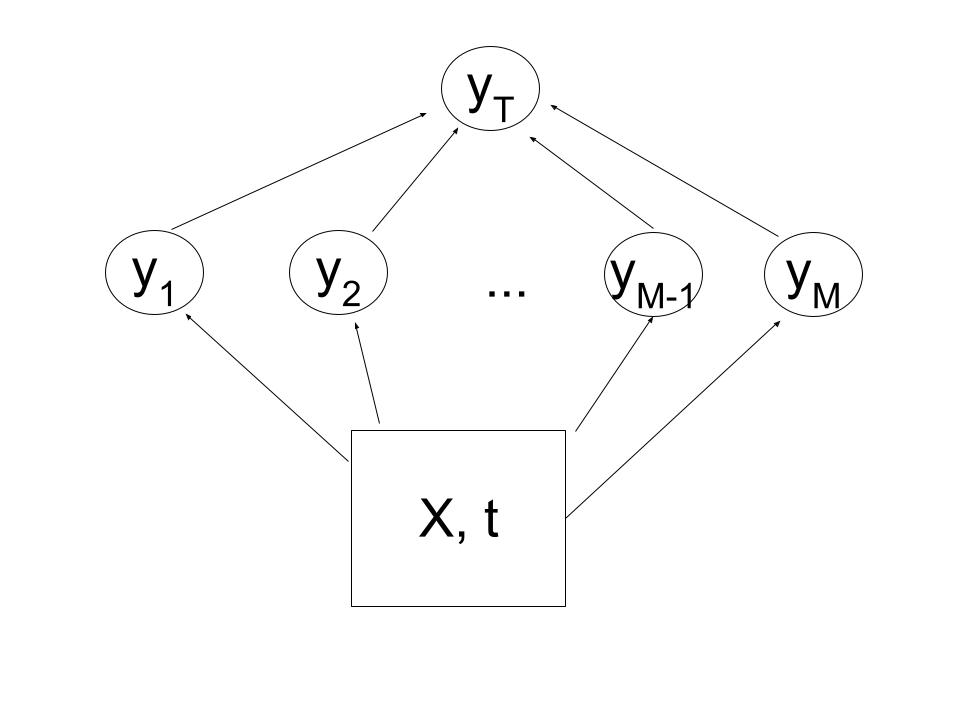

Para ver un ejemplo, volvamos al dataset make_moons que vimos en el contexto de SVC.

Importamos, separamos en Train y Test y entrenamos tres algoritmos distintos y su combinacion.

In [2]:
X, y = datasets.make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


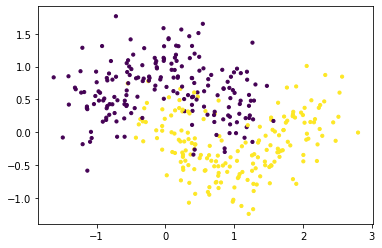

In [3]:
plt.scatter(X_train[:,0],X_train[:,1],c=y_train,s=10)

In [8]:
log_clf = LogisticRegression(solver="liblinear", random_state=42)
tree_clf = DecisionTreeClassifier(random_state=42,max_depth=5)
svm_clf = SVC(gamma="auto", probability=True, random_state=42)

voting_clf_hard = VotingClassifier(
    estimators=[('lr', log_clf), ('tree', tree_clf), ('svc', svm_clf)],
    voting='hard')

voting_clf_soft = VotingClassifier(
    estimators=[('lr', log_clf), ('tree', tree_clf), ('svc', svm_clf)],
    voting='soft')

voting_clf_hard.fit(X_train, y_train)
voting_clf_soft.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='liblinear', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('tree',
                              DecisionTreeClassifier(ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gi...
                                        

El VotingClassifier tiene como input la opcion voting. Voting='hard' usa las asignaciones de la clase mientras que 'soft' usa las predicciones de la probabilidad.

In [9]:
for clf in (log_clf, tree_clf, svm_clf, voting_clf_hard, voting_clf_soft):
    clf.fit(X_train, y_train)
    y_pred = cross_val_predict(clf,X_train,y_train)
    print(clf.__class__.__name__, accuracy_score(y_train, y_pred))

LogisticRegression 0.84
DecisionTreeClassifier 0.8826666666666667
SVC 0.904
VotingClassifier 0.904
VotingClassifier 0.9093333333333333


Vemos que el ambos VotingClassifier resultan mejores que cada uno de los clasificadores que lo componen. El segundo es con voting="soft" y es claramente mejor que el anterior. Veamos como se ve graficamente.


In [12]:
#Este es el rango de X e Y que se ve bien para nuestro dataset
DEFAULT_AXIS=[-1.5, 2.5, -1, 1.5]

def plot_dataset(X, y, axes=DEFAULT_AXIS):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

def plot_predictions(clf, axes=DEFAULT_AXIS, plot_sv=False, plot_cont=True):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    #y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    # if plot_cont:
    #     plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)
    # if plot_sv:
    #     try:
    #         svs = clf[:-1].inverse_transform(clf.steps[-1][1].support_vectors_)
    #         plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    #     except:
    #         print("LinearSVC no guarda los Support Vectors, para eso us SVC con kernel='linear'")

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

In [11]:
print(log_clf.predict_proba([[1.1,0.35]]))
print(tree_clf.predict_proba([[1.1,0.35]]))
print(svm_clf.predict_proba([[1.1,0.35]]))
print(np.mean([log_clf.predict_proba([[1.1,0.35]]),tree_clf.predict_proba([[1.1,0.35]]),svm_clf.predict_proba([[1.1,0.35]])],axis=0))
print(voting_clf_hard.predict([[1.1,0.35]]))
print(voting_clf_soft.predict_proba([[1.1,0.35]]))
print(voting_clf_soft.predict([[1.1,0.35]]))

[[0.43056628 0.56943372]]
[[0.80952381 0.19047619]]
[[0.86523701 0.13476299]]
[[0.7017757 0.2982243]]
[0]
[[0.7017757 0.2982243]]
[0]


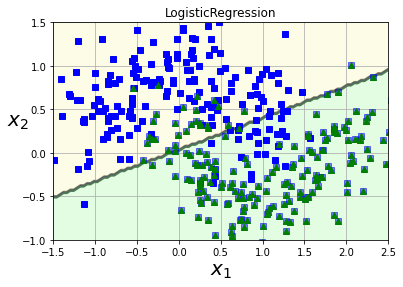

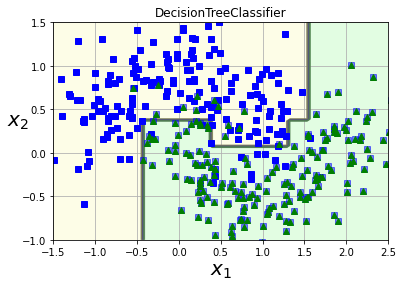

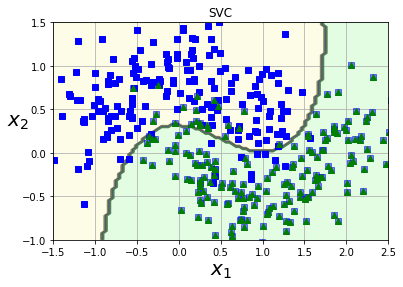

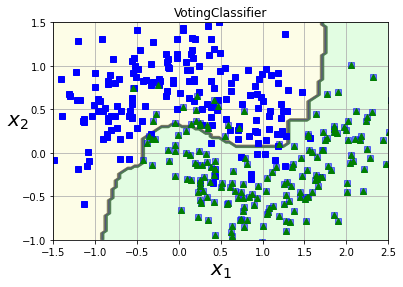

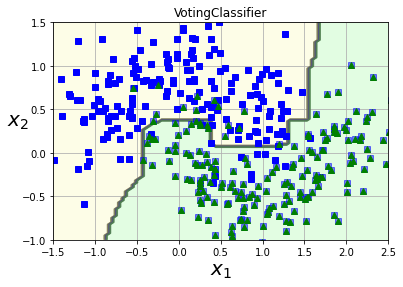

In [13]:
for clf in (log_clf, tree_clf, svm_clf, voting_clf_hard, voting_clf_soft):
    #plot_predictions(clf)
    plt.title(clf.__class__.__name__)
    plot_decision_boundary(clf,X_train,y_train)
    plot_dataset(X_train,y_train)
    plt.show()

Soft:

$$y_{\text{Voting}}=\frac{1}{M}\sum_{m=1}^{M}y_{m}$$

y decide tomando $y_{\text{Voting}}>$ Umbral

In [22]:
for clf in (log_clf, tree_clf, svm_clf, voting_clf_hard, voting_clf_soft):
  print(clf.predict(X_train[voting_clf_hard.predict(X_train)!=voting_clf_soft.predict(X_train)]))

[0 0 0 0 0 0 1 0 0]
[1 1 1 1 1 1 0 1 1]
[0 0 0 0 0 0 1 0 0]
[0 0 0 0 0 0 1 0 0]
[1 1 1 1 1 1 0 1 1]


In [26]:
for clf in (log_clf, tree_clf, svm_clf, voting_clf_soft):
  print(clf.predict_proba(X_train[voting_clf_hard.predict(X_train)!=voting_clf_soft.predict(X_train)])[:,1])

[0.25425384 0.40132614 0.3489802  0.3000067  0.35526427 0.33068247
 0.55402184 0.37209131 0.30932233]
[0.88235294 0.88235294 0.88235294 0.88235294 0.88235294 0.88235294
 0.19047619 0.88235294 0.88235294]
[0.48353829 0.42372736 0.44161322 0.38049231 0.41305911 0.39229264
 0.70437078 0.38721544 0.46994557]
[0.54004836 0.56913548 0.55764879 0.52095065 0.55022544 0.53510935
 0.48295627 0.54721989 0.55387361]


In [32]:
print(voting_clf_soft.named_estimators_['lr'].intercept_)
print(voting_clf_soft.named_estimators_['lr'].coef_)

[0.11419861]
[[ 1.19288294 -3.27665344]]


# Bagging and Pasting

Estos algoritmos agarran un tipo de algoritmo y lo entrenan sobre distintos subconjuntos de los datos, elegidos al azar, y luego utiliza el conjunto de predicciones para hacer una asignacion.

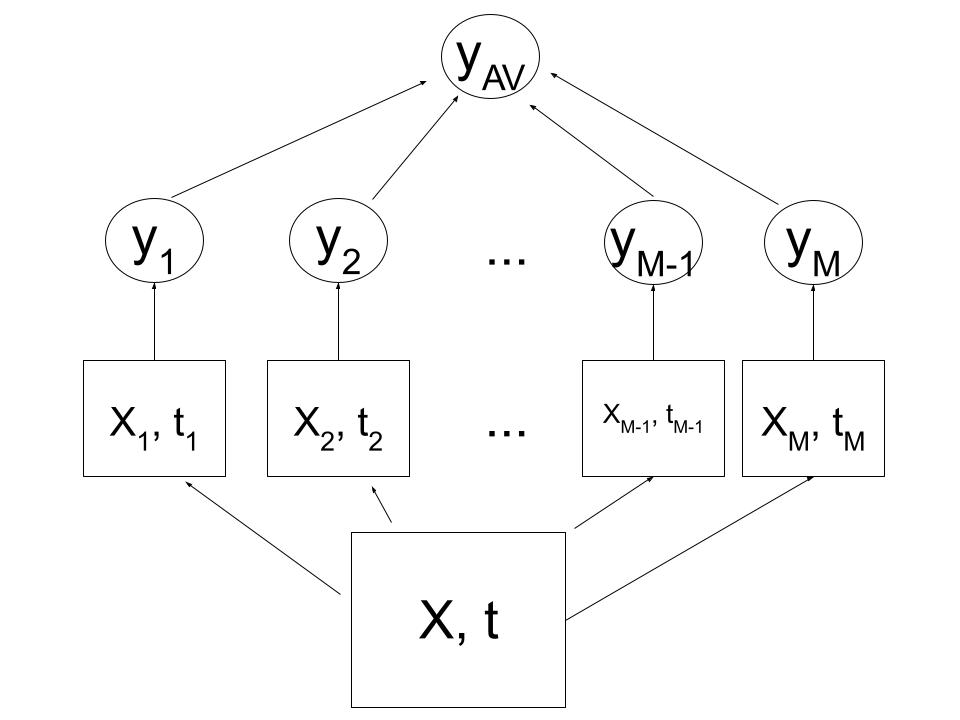

La diferencia entre bagging y pasting es el sampleo de los datos. El sampleo es el siguiente.



1.   Selecciono un predictor.
2.   Elijo una medicion al azar y se la entrego.
3.   Si estoy en bagging, "repongo la medicion", si es en pasting la saco de mi dataset (por ahora).
4.   Extraigo una nueva medicion.
5.   Repito hasta tener un dataset sampleado de cierto tamaño.
6.   Repongo todo el dataset y repito para otro predictor.

Apliquemoslo con make_moons. En la implementacion de scikit-learn, se permite hacer Bagging de muchas copias de un mismo estimador (es decir, todos los estimadores en el Bagging deben ser del mismo algoritmo). Si el algoritmo lo permite se utiliza por defecto la probabilidad. Si no lo permite, se utiliza la prediccion.

In [44]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42,max_features=2)
bag_clf.fit(X_train, y_train)
y_pred = cross_val_predict(bag_clf,X_train,y_train)

print(accuracy_score(y_train, y_pred))

0.9253333333333333


In [47]:
from sklearn.model_selection import GridSearchCV
params={'n_estimators':[400,500, 600]}
grilla=GridSearchCV(bag_clf,params,cv=10,scoring='accuracy')
grilla.fit(X_train,y_train)
print(grilla.best_params_)

{'n_estimators': 500}


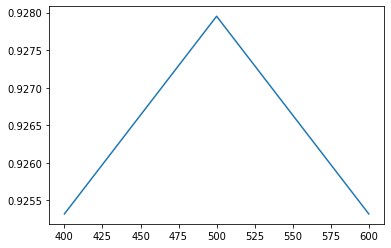

In [48]:
plt.plot(grilla.cv_results_['param_n_estimators'].data,grilla.cv_results_['mean_test_score'])

Los parametros del BaggingClassifier son:

*   n_estimators: el numero de predictores del determinado algoritmo.
*   boostrap: si reemplaza o no la muestra.
*   n_jobs: cuantos nucleos utiliza.
*   max_samples: la maxima cantidad de muestras por predictor.
*   max_features: la maxima cantidad de features por predictor
*   boostrap_features: Si reemplazo o no los features si sampleo en ellos.




Por defecto, el BaggingClassifier samplea $N$ muestras, donde $N$ es el tamaño de nuestro dataset de entrenamiento. Sin embargo, debido al reemplazo, las muestras que utiliza no son las mismas para cada predictor. Ademas, por defecto utiliza todos los features. Si uno utiliza todo el conjunto de entrenamiento pero samplea con reemplazo en los features se llama Random Subspaces. Samplear todo a la vez se llama RandomPatches.

La opcion Out of Bag score permite utilizar las samples que no se utilizaron para entrenar para evaluar el rendimiento del algoritmo. 


In [37]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_depth=None, random_state=42), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9013333333333333

Vemos que se parece bastante al accuracy_score que vimos antes. En particular, podemos tambien obtener la funcion de decision del ensemble en este conjunto. Noten que estoy utilizando el conjunto de entrenamiento para evaluar mi ensemble antes de ir al conjunto de testeo.

In [ ]:
bag_clf.oob_decision_function_

Dicho mal y pronto, BaggingClassifier viene con un CV score incorporado.

Veamos ahora la diferencia con usar un unico DT:

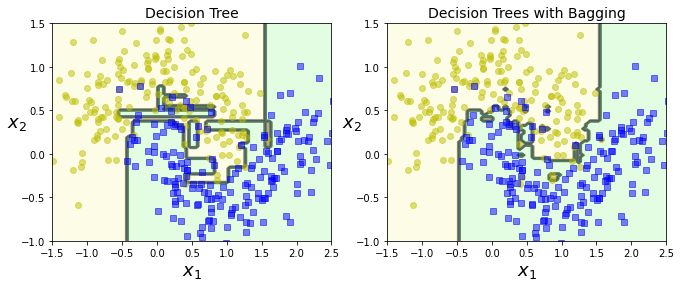

In [39]:
tree_clf=DecisionTreeClassifier(max_depth=None, random_state=42)
tree_clf.fit(X_train,y_train)
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.show()

A ojo, aunque la precision no es mucho mayor, la superficie es mucho mas regular, lo cual lo hace mucho menos propenso al overfitting. Esto sucede usualmente al pasar a metodos de Ensemble.


## Bias-Variance


Podemos ver el efecto de usar modelos con más o menos flexibilidad a la hora de realizar comités. 

En este caso, arranquemos con un DT, con profundidad 1. Obviamente, no va a alcanzar para explicar este dataset.

[[140  49]
 [ 19 167]]
[[149  40]
 [ 40 146]]


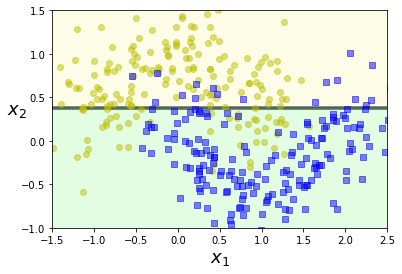

In [40]:
dt = DecisionTreeClassifier(max_depth=1, random_state=107)
dt = dt.fit(X_train, y_train)

plot_decision_boundary(dt, X_train, y_train)
print(confusion_matrix(y_train,dt.predict(X_train)))
print(confusion_matrix(y_train,cross_val_predict(dt,X_train,y_train)))

Pero, ¿qué pasará si combinamos 2000 de estos? ¿Lo lograremos?

[[153  36]
 [ 33 153]]
[[152  37]
 [ 38 148]]


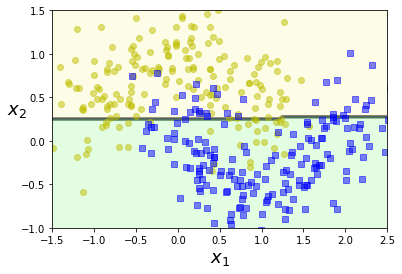

In [41]:
clf = BaggingClassifier(dt, n_estimators=2000, n_jobs=-1, 
                        oob_score=False, max_samples=0.2, bootstrap=True)
clf = clf.fit(X_train, y_train)

plot_decision_boundary(clf, X_train, y_train)
print(confusion_matrix(y_train,clf.predict(X_train)))
print(confusion_matrix(y_train,cross_val_predict(clf,X_train,y_train)))

Funciona mal! Eso es porque el algoritmo de base tiene mucho sesgo y poca varianza. Antes lo habiamos hecho al reves.

# Stacking

El algoritmo de Voting funcionaba bien. Sin embargo, confiabamos en que un conteo alcanzaba para combinar los distintos algoritmos. En Stacking, entrenamos un modelo, llamado `blender` o `meta learner`, para que aprenda a combinar modelos de la mejor manera.

Una manera estandar de entrenar a los algoritmos es la siguiente. Se separa el dataset en dos subconjuntos. Se utiliza el primero para entrenar la primer capa de algoritmos. Luego se utilizan las predicciones de esta primer capa sobre el segundo subconjunto para entrenar al `blender`.

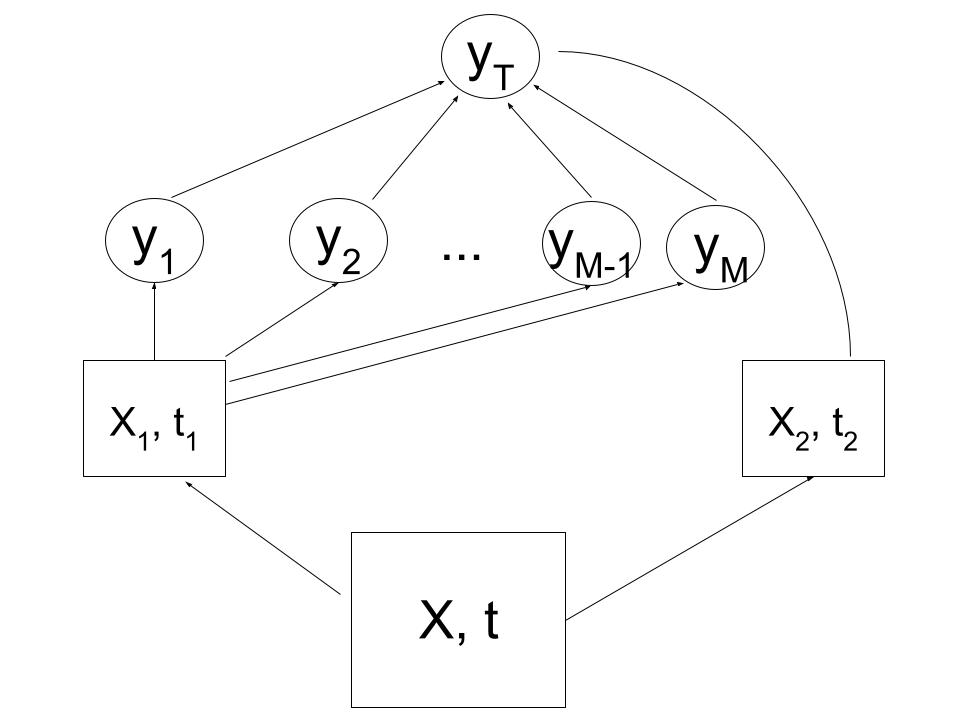

Veamos un ejemplo de esto utilizando el dataset de Boston. Ahora tenemos un problema de **regresión** para cambiar un poco las cosas.

In [49]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.svm import SVR
estimators = [('ridge', RidgeCV()),
              ('lasso', LassoCV(random_state=42)),
              ('lasso2', LassoCV(random_state=107)),
              ('svr', SVR(C=1, gamma=1e-6))]

In [55]:
from sklearn.ensemble import StackingRegressor

reg = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())

In [56]:
from sklearn.datasets import load_boston
X, y = load_boston(return_X_y=True)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print(X_train.shape, X_test.shape)

(379, 13) (127, 13)


In [57]:
# Y se ajusta como siempre, con la magia de sklearn
reg = reg.fit(X_train, y_train)

In [59]:
-np.mean(cross_val_score(reg,X_train, y_train,scoring='neg_mean_squared_error'))

24.77516780049563

Y podemos obtener el output de cada uno con el método `transform`.

In [62]:
print(y_train[:10])
print(X_train[:10])
print(reg.transform(X_train[:10]))

[37.9 15.6 45.4 15.7 22.6 14.5 18.7 17.8 16.1 20.6]
[[9.10300e-02 0.00000e+00 2.46000e+00 0.00000e+00 4.88000e-01 7.15500e+00
  9.22000e+01 2.70060e+00 3.00000e+00 1.93000e+02 1.78000e+01 3.94120e+02
  4.82000e+00]
 [3.53501e+00 0.00000e+00 1.95800e+01 1.00000e+00 8.71000e-01 6.15200e+00
  8.26000e+01 1.74550e+00 5.00000e+00 4.03000e+02 1.47000e+01 8.80100e+01
  1.50200e+01]
 [3.57800e-02 2.00000e+01 3.33000e+00 0.00000e+00 4.42900e-01 7.82000e+00
  6.45000e+01 4.69470e+00 5.00000e+00 2.16000e+02 1.49000e+01 3.87310e+02
  3.76000e+00]
 [3.87350e-01 0.00000e+00 2.56500e+01 0.00000e+00 5.81000e-01 5.61300e+00
  9.56000e+01 1.75720e+00 2.00000e+00 1.88000e+02 1.91000e+01 3.59290e+02
  2.72600e+01]
 [6.72400e-02 0.00000e+00 3.24000e+00 0.00000e+00 4.60000e-01 6.33300e+00
  1.72000e+01 5.21460e+00 4.00000e+00 4.30000e+02 1.69000e+01 3.75210e+02
  7.34000e+00]
 [1.35472e+00 0.00000e+00 8.14000e+00 0.00000e+00 5.38000e-01 6.07200e+00
  1.00000e+02 4.17500e+00 4.00000e+00 3.07000e+02 2.10000e+

In [65]:
reg.estimators_[0].coef_

array([-1.27536016e-01,  2.98537818e-02,  4.35486432e-02,  2.74033483e+00,
       -1.49671032e+01,  4.37348397e+00, -1.03183435e-02, -1.38208336e+00,
        2.55296380e-01, -1.00999170e-02, -9.07649627e-01,  1.32371414e-02,
       -5.20257280e-01])

In [63]:
reg.final_estimator_.coef_

array([0.9169924 , 0.02930417, 0.02930417, 0.0171989 ])

### Multilayer

Stacking multilayer no está implementado en `sklearn`. Se puede hacer a mano combinando `Stacking`s.

In [68]:
from sklearn.ensemble import RandomForestRegressor

final_layer = StackingRegressor(estimators=[('rf', RandomForestRegressor(random_state=42)),
                                            ('gbrt', GradientBoostingRegressor(random_state=42))],
                                final_estimator=RidgeCV())

multi_layer_regressor = StackingRegressor(estimators=[('ridge', RidgeCV()),
                                                      ('lasso', LassoCV(random_state=42)),
                                                      ('svr', SVR(C=1, gamma=1e-6, kernel='rbf'))],
                                          final_estimator=final_layer)

multi_layer_regressor.fit(X_train, y_train)
print('R2 score: {:.2f}'.format(multi_layer_regressor.score(X_test, y_test)))
print(multi_layer_regressor.score(X_test, y_test))

R2 score: 0.82
0.823396530962474
